In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score


from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [2]:
data_folder = Path("/home/aniket/Music/notebooks/data/titanic")

In [3]:
train_data = pd.read_csv(data_folder/"train.csv")
test_data = pd.read_csv(data_folder/"test.csv")

#test_label = pd.read_csv(data_folder/"gender_submission.csv")

In [4]:
#test_data = test_data.set_index('PassengerId').join(test_label.set_index('PassengerId'))
#test_data.reset_index(inplace=True)

test_data.head()

In [5]:
train_data.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
pat = '\s([A-Za-z]+)\.'

In [7]:
train_data['title'] = train_data['Name'].str.extract(pat = pat)
test_data['title'] = test_data['Name'].str.extract(pat = pat)

In [8]:
train_data['title'] = train_data.title.map(defaultdict(lambda: 3,Mr= 0, Mrs= 1, Miss= 2),na_action='ignore')
test_data['title'] = test_data.title.map(defaultdict(lambda: 3,Mr= 0, Mrs= 1, Miss= 2),na_action='ignore')

In [9]:
train_data[['Pclass','Fare']].groupby(['Pclass'],as_index=False).mean()

,Pclass,Fare
0,1,84.154687
1,2,20.662183
2,3,13.675550


In [10]:
train_data['familyMembers'] = train_data['SibSp'] + train_data['Parch'] 
test_data['familyMembers'] = test_data['SibSp'] + test_data['Parch'] 


In [11]:
train_data['familyMembers'] .head()

0    1
1    1
2    0
3    1
4    0
Name: familyMembers, dtype: int64

In [12]:
train_data.loc[train_data['familyMembers'] == 0, 'solo'] = 1
train_data.loc[train_data['familyMembers'] > 0, 'solo'] = 0

test_data.loc[train_data['familyMembers'] == 0, 'solo'] = 1
test_data.loc[train_data['familyMembers'] > 0, 'solo'] = 0

In [13]:
train_data.solo.head()

0    0.0
1    0.0
2    1.0
3    0.0
4    1.0
Name: solo, dtype: float64

In [14]:
category = pd.cut(train_data.Age,bins=[0,15,30,45,65,99],labels=['A1','A2','A3','A4','A5'])
train_data.insert(5,'AgeGroup',category)

category = pd.cut(train_data.Fare,bins=[0,50,1000],labels=['High','Low'])
train_data.insert(6,'FareGroup',category)

In [15]:
category = pd.cut(test_data.Age,bins=[0,15,30,45,65,99],labels=['A1','A2','A3','A4','A5'])
test_data.insert(5,'AgeGroup',category)

category = pd.cut(test_data.Fare,bins=[0,50,1000],labels=['High','Low'])
test_data.insert(6,'FareGroup',category)

In [16]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,AgeGroup,FareGroup,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,familyMembers,solo
0,1,0,3,"Braund, Mr. Owen Harris",male,A2,High,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,A3,Low,38.0,1,0,PC 17599,71.2833,C85,C,1,1,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,A2,High,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2,0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,A3,Low,35.0,1,0,113803,53.1000,C123,S,1,1,0.0
4,5,0,3,"Allen, Mr. William Henry",male,A3,High,35.0,0,0,373450,8.0500,NaN,S,0,0,1.0


In [17]:
train_data[['Fare','Pclass']].groupby('Pclass').std()

,Fare
Pclass,
1,78.380373
2,13.417399
3,11.778142


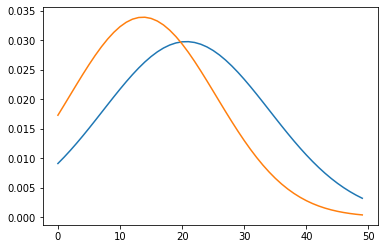

In [18]:
x_axis = np.arange(0, 50, 1)
plt.plot(norm.pdf(x_axis,20.662183,13.417399),label = 'Pclass2')
plt.plot(norm.pdf(x_axis,13.675550,11.778142),label = 'Pclass3')

In [19]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'AgeGroup',
       'FareGroup', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked', 'title', 'familyMembers', 'solo'],
      dtype='object')

In [20]:
train_data.replace([np.inf, -np.inf], np.nan,inplace=True)
test_data.replace([np.inf, -np.inf], np.nan,inplace=True)

In [21]:
features_used_to_train = ['Pclass','Sex','Embarked', 'AgeGroup','FareGroup',"solo","title"]

In [22]:
X = train_data[features_used_to_train]
X_pred = test_data[features_used_to_train]

In [23]:
y = train_data['Survived']
#Y_test = test_data['Survived']

In [24]:
X.head()

,Pclass,Sex,Embarked,AgeGroup,FareGroup,solo,title
0,3,male,S,A2,High,0.0,0
1,1,female,C,A3,Low,0.0,1
2,3,female,S,A2,High,1.0,2
3,1,female,S,A3,Low,0.0,1
4,3,male,S,A3,High,1.0,0


In [25]:
numericalColumns = [
]

categoricalColumns = [
    "Pclass",
    "Sex",
    "Embarked",
    "AgeGroup",
    "FareGroup",
    "solo",
    "title"
]

In [26]:
#imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
#imp_most_frequent = SimpleImputer(missing_values=np.nan, ,strategy='most_frequent')
ctImputer = ColumnTransformer([
                        ("Imputer1", SimpleImputer(missing_values=np.nan, strategy='most_frequent'),categoricalColumns )
                 #       ,("Imputer2", SimpleImputer(missing_values=np.nan, strategy='median'), numericalColumns)
                        ],
                       remainder="passthrough")

ctEncoder = ColumnTransformer([
                        ("Encoding", OneHotEncoder(),[0,1,2,3,4,5,6])
                        ],
                       remainder="passthrough")

ctNormalization = ColumnTransformer([
                        ("Normalization", MinMaxScaler(),[])
                        ],
                       remainder="passthrough")



In [27]:
X.isna().any()

Pclass       False
Sex          False
Embarked      True
AgeGroup      True
FareGroup     True
solo         False
title        False
dtype: bool

In [28]:
X= ctImputer.fit_transform(X)

In [29]:
X[0]

array([3, 'male', 'S', 'A2', 'High', 0.0, 0], dtype=object)

In [30]:
X = ctEncoder.fit_transform(X)

In [31]:
#X= ctNormalization.fit_transform(X)

In [32]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X
y_train = y

In [33]:
X_pred = ctImputer.transform(X_pred)
X_pred = ctEncoder.transform(X_pred)
#X_pred = ctNormalization.fit_transform(X_pred)

In [34]:
#np.where(pd.isnull(X_pred))

In [35]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
#clf = svm.SVC(C=10000,kernel='rbf',gamma=0.001)
#clf = AdaBoostClassifier(n_estimators=40, random_state=0)
#clf = KNeighborsClassifier(n_neighbors=3)

In [36]:
#clf.fit(X_train,y_train)
clf.fit(X_train,y_train)

/home/aniket/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

y_test_pred= clf.predict(X_test)
accuracy_score(y_test,y_test_pred)

scores = cross_val_score(clf,X,y,cv = 5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [37]:

y_pred= clf.predict(X_pred)

res = pd.DataFrame({'PassengerId' : test_data['PassengerId'].values,'Survived' : y_pred}
                   ,columns=['PassengerId','Survived'])

res.to_csv(data_folder/"output.csv" , index=False)

In [38]:
mask = ((y_test != y_test_pred) & (y_test == 0))
falsePositive = y_test[mask].index

NameError: name 'y_test' is not defined

In [ ]:
mask = ((y_test != y_test_pred) & (y_test == 1))
falseNegative = y_test[mask].index

In [ ]:
train_data.iloc[falseNegative]

In [ ]:
confusion_matrix(y_test, y_test_pred)

In [ ]:
len(X_train[0,:])

In [ ]:
train_data.groupby('Embarked').mean()